<a href="https://colab.research.google.com/github/vladi29/ANA-Classifier/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Universidad Simon Bolivar - 26 de Enero de 2022
# Trabajo final de grado: Clasificador de patrones ANA
# Vladimir Alfaro - 1510023

# Creacion, entrenamiento y prueba de la red

import torch.nn as nn
import torch.nn.functional as F
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd
import os

Image name:  ['656_1.jpg']
Label:  Negative
Image name:  ['149_3.tif']
Label:  FineSpeckled_CytoplasmicReticularAMA
Image name:  ['97_1.bmp']
Label:  DSF-70
Image name:  ['889_1.png']
Label:  Negative
Image name:  ['125_3.jpg']
Label:  FineSpeckled
Image name:  ['58_2.bmp']
Label:  CoarseSpeckled_NucleolarHomogeneous


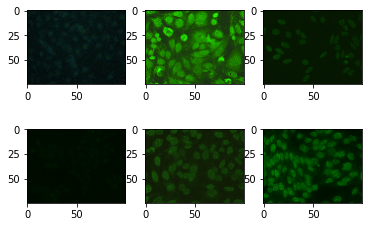

In [ ]:
#----------Paths----------

labels_path = 'drive/MyDrive/Colab_Notebooks/Tesis/Preprocessing/labels.csv'
names_path = 'drive/MyDrive/Colab_Notebooks/Tesis/Preprocessing/names.csv'
images_path = 'drive/MyDrive/Colab_Notebooks/Tesis/Preprocessing/images.npz'

labels_raw = pd.read_csv(labels_path, header = None)
labels_raw = labels_raw.values.tolist()
labels = []
for label in labels_raw:
  labels.append(label[0])

names = pd.read_csv(names_path, header = None)
names = names.values.tolist()

images = np.load(images_path)
images = images['arr_0']

images_list = []
labels_list = []
names_list = []

for i in range(0, 6):
    A = random.randint(0, 2079)
    images_list.append(images[A])
    labels_list.append(labels[A])
    names_list.append(names[A])

for i in range(0,6):
    plt.subplot(2,3, i+1)
    imagen = images_list[i]
    print("Image name: ", names_list[i])
    print("Label: ", labels_list[i])
    plt.imshow(imagen)
plt.show()

In [ ]:
#Preparando la data para cambiar las clases por 1 para positivos y 0 para negativos

binary_labels = []
for label in labels:
  if label == 'Negative':
    binary_labels.append(0)
  else: 
    binary_labels.append(1)

#Division de la data para entrenar y probar la red

#x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size = 0.2)
x_train, x_test, y_train, y_test = train_test_split(images, binary_labels, test_size = 0.2)

tensor(0)


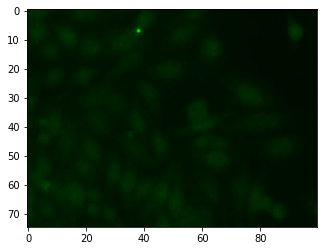

In [ ]:
#Clase Dataset Personaliazdo

class CustomImageDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.labels = labels
        self.images = images
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)
        
        return image, label

#Creando Dataloader para los conjuntos de entrenamiento y prueba
       
train_data = CustomImageDataset(x_train, y_train)
train_dataloader = DataLoader(train_data, batch_size=32, shuffle=False)

test_data = CustomImageDataset(x_test, y_test)
test_dataloader = DataLoader(test_data, batch_size=32, shuffle=False)

images, labels = next(iter(train_dataloader))
plt.imshow(images[0])
print(labels[0])

In [ ]:
# Creacion de la LeNet

class LeNet(nn.Module):
  def __init__(self, numChannels, numClasses):
    super(LeNet, self).__init__()

    # initialize first set of CONV => RELU => POOL layers
    self.conv1 = nn.Conv2d(in_channels=numChannels, out_channels=20, kernel_size=(5, 5))
    self.relu1 = nn.ReLU()
    self.maxpool1 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

    # initialize second set of CONV => RELU => POOL layers
    self.conv2 = nn.Conv2d(in_channels=20, out_channels=50,kernel_size=(5, 5))
    self.relu2 = nn.ReLU()
    self.maxpool2 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

    # initialize first (and only) set of FC => RELU layers
    self.fc1 = nn.Linear(in_features=800, out_features=500)
    self.relu3 = nn.ReLU()

    # initialize our softmax classifier
    self.fc2 = nn.Linear(in_features=500, out_features=numClasses)
    self.logSoftmax = nn.LogSoftmax(dim=1)

  def forward(self, x):

    # pass the input through our first set of CONV => RELU =>
    # POOL layers
    x = self.conv1(x)
    x = self.relu1(x)
    x = self.maxpool1(x)
    # pass the output from the previous layer through the second
    # set of CONV => RELU => POOL layers
    x = self.conv2(x)
    x = self.relu2(x)
    x = self.maxpool2(x)
    # flatten the output from the previous layer and pass it
    # through our only set of FC => RELU layers
    x = nn.flatten(x, 1)
    x = self.fc1(x)
    x = self.relu3(x)
    # pass the output to our softmax classifier to get our output
    # predictions
    x = self.fc2(x)
    output = self.logSoftmax(x)
    # return the output predictions
    return output

def train(model, optimizer, loss_fn, train_loader, val_loader, epochs=20, device="cuda"):

  for epoch in range(epochs):
    training_loss = 0.0
    valid_loss = 0.0
    model.train()
    for batch in train_loader:
      optimizer.zero_grad()
      inputs, targets = batch
      inputs = inputs.to(device)
      target = targets.to(device)
      output = model(inputs)
      loss = loss_fn(output, target)
      loss.backward()
      optimizer.step()
      training_loss += loss.data.item()
    training_loss /= len(train_iterator)

    model.eval()
    num_correct = 0
    num_examples = 0
    for batch in val_loader:
      inputs, targets = batch
      inputs = inputs.to(device)
      output = model(inputs)
      targets = targets.to(device)
      loss = loss_fn(output,targets)
      valid_loss += loss.data.item()
      correct = torch.eq(torch.max(F.softmax(output), dim=1)[1],
      target).view(-1)
      num_correct += torch.sum(correct).item()
      num_examples += correct.shape[0]
    valid_loss /= len(valid_iterator)
    
    print('Epoch: {}, Training Loss: {:.2f},
    Validation Loss: {:.2f},
    accuracy = {:.2f}'.format(epoch, training_loss,
    valid_loss, num_correct / num_examples))